# Chapter: Recurrent Neural Networks


# Topic: RNN-based TEP fault classification

In [20]:
# import required packages
import numpy as np
import matplotlib.pyplot as plt

In [21]:
# read data
import pyreadr
fault_free_training_data = pyreadr.read_r('TEP_FaultFree_Training.RData')['fault_free_training'] # pandas dataframe
fault_free_testing_data = pyreadr.read_r('TEP_FaultFree_Testing.RData')['fault_free_testing']
faulty_training_data = pyreadr.read_r('TEP_Faulty_Training.RData')['faulty_training']
faulty_testing_data = pyreadr.read_r('TEP_Faulty_Testing.RData')['faulty_testing']

fault_free_training_data.head()

,faultNumber,simulationRun,sample,xmeas_1,xmeas_2,xmeas_3,xmeas_4,xmeas_5,xmeas_6,xmeas_7,...,xmv_2,xmv_3,xmv_4,xmv_5,xmv_6,xmv_7,xmv_8,xmv_9,xmv_10,xmv_11
0,0.0,1.0,1,0.25038,3674.0,4529.0,9.2320,26.889,42.402,2704.3,...,53.744,24.657,62.544,22.137,39.935,42.323,47.757,47.510,41.258,18.447
1,0.0,1.0,2,0.25109,3659.4,4556.6,9.4264,26.721,42.576,2705.0,...,53.414,24.588,59.259,22.084,40.176,38.554,43.692,47.427,41.359,17.194
2,0.0,1.0,3,0.25038,3660.3,4477.8,9.4426,26.875,42.070,2706.2,...,54.357,24.666,61.275,22.380,40.244,38.990,46.699,47.468,41.199,20.530
3,0.0,1.0,4,0.24977,3661.3,4512.1,9.4776,26.758,42.063,2707.2,...,53.946,24.725,59.856,22.277,40.257,38.072,47.541,47.658,41.643,18.089
4,0.0,1.0,5,0.29405,3679.0,4497.0,9.3381,26.889,42.650,2705.1,...,53.658,28.797,60.717,21.947,39.144,41.955,47.645,47.346,41.507,18.461


In [22]:
# remove fault 3,9,15 data from faulty dataset
faulty_training_data = faulty_training_data[faulty_training_data['faultNumber'] != 3]
faulty_training_data = faulty_training_data[faulty_training_data['faultNumber'] != 9]
faulty_training_data = faulty_training_data[faulty_training_data['faultNumber'] != 15]

faulty_testing_data = faulty_testing_data[faulty_testing_data['faultNumber'] != 3]
faulty_testing_data = faulty_testing_data[faulty_testing_data['faultNumber'] != 9]
faulty_testing_data = faulty_testing_data[faulty_testing_data['faultNumber'] != 15]

In [23]:
# separate validation dataset out of training dataset and create imbalanced faulty dataset
fault_free_validation_data = fault_free_training_data[fault_free_training_data['simulationRun'] > 400]
fault_free_training_data = fault_free_training_data[fault_free_training_data['simulationRun'] <= 400]
faulty_validation_data = faulty_training_data[faulty_training_data['simulationRun'] > 490] 
faulty_training_data = faulty_training_data[faulty_training_data['simulationRun'] <= 50]

# convert to numpy
fault_free_training_data = fault_free_training_data.values
fault_free_validation_data = fault_free_validation_data.values
fault_free_testing_data = fault_free_testing_data.values
faulty_training_data = faulty_training_data.values
faulty_validation_data = faulty_validation_data.values
faulty_testing_data = faulty_testing_data.values

In [24]:
# complete training, validation, and test datasets
training_data = np.vstack((fault_free_training_data,faulty_training_data))
validation_data = np.vstack((fault_free_validation_data,faulty_validation_data))
testing_data = np.vstack((fault_free_testing_data,faulty_testing_data))

# separate X and y data
X_train = training_data[:,3:]
X_val = validation_data[:,3:]
X_test = testing_data[:,3:]

y_train = training_data[:,0]
y_val = validation_data[:,0]
y_test = testing_data[:,0]

# scale data
from sklearn.preprocessing import StandardScaler

X_scaler = StandardScaler()
X_train_scaled = X_scaler.fit_transform(X_train)
X_val_scaled = X_scaler.transform(X_val)
X_test_scaled = X_scaler.transform(X_test)

In [ ]:
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
##                         re-arrage data with time steps 
## %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

In [25]:
# rearrange X data into (# sequence samples, # time steps, # features) form
nTimeStepsTrain = 500 # length of a simulation run in training data 
nTimeStepsTest = 960 # length of a simulation run in testing data 
X_train_sequence = []
y_train_sequence = []
X_val_sequence = []
y_val_sequence = []
X_test_sequence = []
y_test_sequence = []

for sample in range(0, X_train_scaled.shape[0], nTimeStepsTrain):
    X_train_sequence.append(X_train_scaled[sample:sample+nTimeStepsTrain,:])
    y_train_sequence.append(y_train[sample])
    
for sample in range(0, X_val_scaled.shape[0], nTimeStepsTrain):
    X_val_sequence.append(X_val_scaled[sample:sample+nTimeStepsTrain,:])
    y_val_sequence.append(y_val[sample])    

for sample in range(0, X_test_scaled.shape[0], nTimeStepsTest):
    X_test_sequence.append(X_test_scaled[sample:sample+nTimeStepsTest,:])
    y_test_sequence.append(y_test[sample])
    
X_train_sequence, y_train_sequence = np.array(X_train_sequence), np.array(y_train_sequence) 
X_val_sequence, y_val_sequence = np.array(X_val_sequence), np.array(y_val_sequence)
X_test_sequence, y_test_sequence = np.array(X_test_sequence), np.array(y_test_sequence)

In [26]:
# convert fault class labels to one-hot encoded form
from tensorflow.keras.utils import to_categorical
Y_train_sequence = to_categorical(y_train_sequence, num_classes=21)
Y_val_sequence = to_categorical(y_val_sequence, num_classes=21)
Y_test_sequence = to_categorical(y_test_sequence, num_classes=21) 

In [ ]:
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
##                          fit LSTM model
## %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

In [27]:
# import packages
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras import regularizers

# define model
model = Sequential()
model.add(LSTM(units=128, kernel_regularizer=regularizers.L1(0.0001), return_sequences=True, input_shape=(nTimeStepsTrain,52)))
model.add(LSTM(units=64, kernel_regularizer=regularizers.L1(0.0001)))
model.add(Dense(21, activation='softmax'))

# model summary
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 500, 128)          92672     
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_2 (Dense)              (None, 21)                1365      
Total params: 143,445
Trainable params: 143,445
Non-trainable params: 0
_________________________________________________________________


In [28]:
# compile model
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

# fit model with early stopping
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
history = model.fit(X_train_sequence, Y_train_sequence, epochs=100, batch_size=250, validation_data=(X_val_sequence,Y_val_sequence), callbacks=[es])

Epoch 1/100
5/5 [==============================] - 14s 3s/step - loss: 3.1957 - accuracy: 0.3152 - val_loss: 2.9028 - val_accuracy: 0.5593
Epoch 2/100
5/5 [==============================] - 14s 3s/step - loss: 2.7053 - accuracy: 0.5384 - val_loss: 2.3714 - val_accuracy: 0.5556
Epoch 3/100
5/5 [==============================] - 14s 3s/step - loss: 2.3054 - accuracy: 0.5312 - val_loss: 2.1417 - val_accuracy: 0.5741
Epoch 4/100
5/5 [==============================] - 15s 3s/step - loss: 2.1375 - accuracy: 0.5672 - val_loss: 1.9924 - val_accuracy: 0.5963
Epoch 5/100
5/5 [==============================] - 16s 3s/step - loss: 1.9842 - accuracy: 0.5824 - val_loss: 1.8923 - val_accuracy: 0.6000
Epoch 6/100
5/5 [==============================] - 16s 3s/step - loss: 1.8643 - accuracy: 0.5952 - val_loss: 1.7750 - val_accuracy: 0.6148
Epoch 7/100
5/5 [==============================] - 16s 3s/step - loss: 1.9354 - accuracy: 0.5416 - val_loss: 1.7275 - val_accuracy: 0.6185
Epoch 8/100
5/5 [==========

5/5 [==============================] - 18s 4s/step - loss: 1.0176 - accuracy: 0.7824 - val_loss: 0.9893 - val_accuracy: 0.8000
Epoch 60/100
5/5 [==============================] - 18s 4s/step - loss: 0.8995 - accuracy: 0.8048 - val_loss: 0.9301 - val_accuracy: 0.8037
Epoch 61/100
5/5 [==============================] - 18s 4s/step - loss: 0.8736 - accuracy: 0.8096 - val_loss: 0.8574 - val_accuracy: 0.8185
Epoch 62/100
5/5 [==============================] - 18s 4s/step - loss: 0.7997 - accuracy: 0.8160 - val_loss: 0.8141 - val_accuracy: 0.8333
Epoch 63/100
5/5 [==============================] - 18s 4s/step - loss: 0.7504 - accuracy: 0.8296 - val_loss: 0.7457 - val_accuracy: 0.8704
Epoch 64/100
5/5 [==============================] - 18s 4s/step - loss: 0.7514 - accuracy: 0.8600 - val_loss: 0.7536 - val_accuracy: 0.8704
Epoch 65/100
5/5 [==============================] - 18s 4s/step - loss: 0.7015 - accuracy: 0.8728 - val_loss: 0.7422 - val_accuracy: 0.8741
Epoch 66/100
5/5 [===============

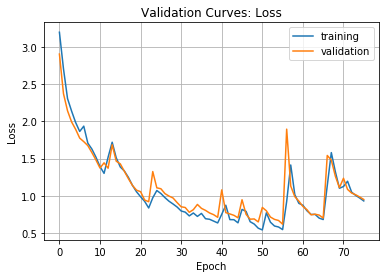

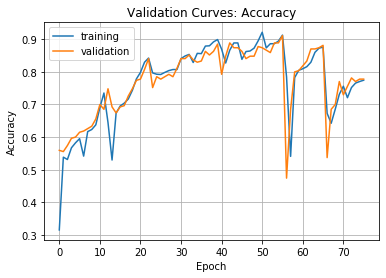

In [29]:
# plot validation curve
plt.figure()
plt.title('Validation Curves: Loss')
plt.xlabel('Epoch'), plt.ylabel('Loss')
plt.plot(history.history['loss'], label='training')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.grid()
plt.show()

plt.figure()
plt.title('Validation Curves: Accuracy')
plt.xlabel('Epoch'), plt.ylabel('Accuracy')
plt.plot(history.history['accuracy'], label='training')
plt.plot(history.history['val_accuracy'], label='validation')
plt.legend()
plt.grid()
plt.show()

In [ ]:
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
##                         evaluate model on test dataset
## %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

Text(0.5, 7.5, 'Predicted Fault Class')

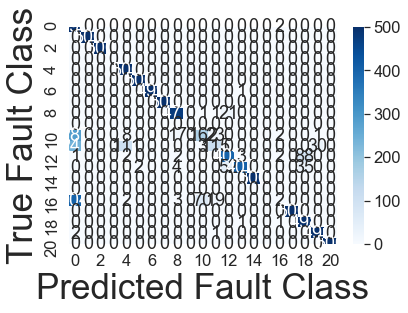

In [30]:
# generate confusion matrix
from sklearn.metrics import confusion_matrix

Y_test_sequence_pred = model.predict(X_test_sequence)
y_test_sequence_pred = np.argmax(Y_test_sequence_pred, axis = 1)
conf_matrix = confusion_matrix(y_test_sequence, y_test_sequence_pred, labels=list(range(21)))

# plot confusion matrix
import seaborn as sn

sn.set(font_scale=1.5) # for label size
sn.heatmap(conf_matrix, fmt='.0f', annot=True, cmap='Blues')
plt.ylabel('True Fault Class', fontsize=35)
plt.xlabel('Predicted Fault Class', fontsize=35)